### This is a new version of MLEAP scripts, started in late Aug 2022.
It will combine IProject_MLEAP_ANN and IP_MLEAP script, while improving them.

#### Outline

1. Load libraries and data.
2. pEDA. Look at feature distribution, fix them if they do not look right.
3. Train-test split. Most likely couple years into test set. 2015-2018?. Impute missing values.
4. Transform numerical features, add ohe for inds.
5. Fit xgb as a baseline, then xgb optuna.
6. Fit DL.



In [74]:
# 0. Import libraries #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, time, math, re, warnings, random, gc, dill, optuna, pickle, shap
import statsmodels.api as sm
from random import sample

from sklearn.model_selection import train_test_split, KFold, PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNetCV
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBRegressor
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

plt.style.use('seaborn-white')
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 110)
gc.enable()

In [75]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [76]:
# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [77]:
#min_prd_list = range(100, 676, 25)
min_prd_list = [250]
# min_prd_list = [150, 250, 350, 450, 550, 650]
#min_prd = min_prd_list[0]
windows_width = 3*12
cv_regularizer=0.2
optuna_trials = 20
time0 = time.time()

results = pd.DataFrame(columns = ['min_prd', 'xgbf_train', 'xgbf_val', 'xgbf_test', 
                                  'xgbgs_train', 'xgbgs_val', 'xgbgs_test', 
                                  'xgbo_train', 'xgbo_val', 'xgbo_test',
                                  'nn2_train', 'nn2_val', 'nn2_test',
                                  'nn4_train', 'nn4_val', 'nn4_test',
                                 'nn6_train', 'nn6_val', 'nn6_test',
                                 'nn4opt_train', 'nn4opt_val', 'nn4opt_test'])
results.min_prd = min_prd_list

for min_prd in min_prd_list:

    with open('../input/mleap-46-preprocessed/MLEAP_46_v7.pkl', 'rb') as pickled_one:
        df = pickle.load(pickled_one)
    df = df[df.prd.isin(range(min_prd-1, min_prd+windows_width+10))]
    df_cnt = df.count()
    empty_cols = list(df_cnt[df_cnt<int(df.shape[0]/2)].index)
    df.drop(columns=empty_cols, inplace=True)
    #display(df.shape, df.head(), df.year.describe(), df.count())

    features_miss_dummies = ['amhd', 'BAspr']
    for col in features_miss_dummies:
        if col in df.columns:
            df[col+'_miss'] = df[col].isnull().astype(int)

    temp_cols = ['PERMNO', 'year', 'prd']
    df.reset_index(inplace=True, drop=True)
    X = df.copy()
    y = X.pop('RET')

    train_indx = X.prd<(min_prd+windows_width-1)
    val_indx = X['prd'].isin(range(min_prd+windows_width-1, min_prd+windows_width+2))
    val_indx_extra = X['prd'].isin(range(min_prd+windows_width+5, min_prd+windows_width+8))
    test_indx = X['prd'].isin(range(min_prd+windows_width+2, min_prd+windows_width+5))

    X_train = X[train_indx]
    X_val = X[val_indx]
    X_val_extra = X[val_indx_extra]
    X_test = X[test_indx]
    y_train = y[train_indx]
    y_val = y[val_indx]
    y_val_extra = y[val_indx_extra]
    y_test = y[test_indx]

    #display(X_train.head(3), X_train.tail(3), y_train.head(3), y_train.tail(3))
    display(X_train.shape, X_val.shape, X_test.shape, X_train.prd.describe(), X_val.prd.describe(), X_test.prd.describe())

    X_train.drop(columns=temp_cols, inplace=True)
    X_val.drop(columns=temp_cols, inplace=True)
    X_val_extra.drop(columns=temp_cols, inplace=True)
    X_test.drop(columns=temp_cols, inplace=True)

    #display(X_train.tail())
    col_cat = ['ind']
    col_num = [x for x in X_train.columns if x not in col_cat]
    for col in col_num:
        X_train[col] = X_train[col].fillna(X_train[col].median())
        X_val[col] = X_val[col].fillna(X_train[col].median())
        X_val_extra[col] = X_val_extra[col].fillna(X_train[col].median())
        X_test[col] = X_test[col].fillna(X_train[col].median())
    for col in col_cat:
        X_train[col] = X_train[col].fillna(value=-1000)
        X_val[col] = X_val[col].fillna(value=-1000)
        X_val_extra[col] = X_val_extra[col].fillna(value=-1000)
        X_test[col] = X_test[col].fillna(value=-1000)

    #display(X_train.tail())
    feature_transformer = ColumnTransformer([('num', StandardScaler(), col_num),
                                            ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), col_cat)], 
                                            remainder="passthrough")

    print('Number of features before transformation: ', X_train.shape)
    train_index, val_index, val_index_extra, test_index = X_train.index, X_val.index, X_val_extra.index, X_test.index
    X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
    X_val = pd.DataFrame(feature_transformer.transform(X_val), columns=feature_transformer.get_feature_names_out())
    X_val_extra = pd.DataFrame(feature_transformer.transform(X_val_extra), columns=feature_transformer.get_feature_names_out())
    X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
    print('time to do feature proprocessing: ')
    print('Number of features after transformation: ', X_train.shape, X_val.shape, X_val_extra.shape, X_test.shape)
    X_train.index = train_index
    X_val.index = val_index
    X_val_extra.index = val_index_extra
    X_test.index = test_index
    #display(X_train.tail())

    X = pd.concat([X_train, X_val])
    y = pd.concat([y_train, y_val])
    #display(X,y)

    X_ = pd.concat([X_train, X_val, X_val_extra])
    y_ = pd.concat([y_train, y_val, y_val_extra])
    #display(X,y, X_,y_)

    print('mae of a constant model', mean_absolute_error(df.RET, np.ones(df.shape[0])*(df.RET.mean())))
    print('R2 of a constant model', r2_score(df.RET, np.ones(df.shape[0])*(df.RET.mean())))

    xgb1 = XGBRegressor(tree_method = 'gpu_hist', n_estimators=400, max_depth=4, eta=0.02, colsample_bytree=0.4, subsample=0.6)
    xgb1.fit(X_train, y_train)
    print('fixed XGB train:', mean_absolute_error(y_train, xgb1.predict(X_train)), r2_score(y_train, xgb1.predict(X_train)))
    print('XGB val:', mean_absolute_error(y_val, xgb1.predict(X_val)), r2_score(y_val, xgb1.predict(X_val)))
    print('XGB val extra:', mean_absolute_error(y_val_extra, xgb1.predict(X_val_extra)), r2_score(y_val_extra, xgb1.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_score(y_test, xgb1.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbf_train':'xgbf_test'] = \
    [r2_score(y_train, xgb1.predict(X_train)), 
    r2_score(y_val, xgb1.predict(X_val)),
    r2_score(y_test, xgb1.predict(X_test))]

    time1 = time.time()

    # Create a list where train data indices are -1 and validation data indices are 0
    split_index = [-1 if x in X_train.index else 0 for x in X.index]
    pds = PredefinedSplit(test_fold = split_index)

    xgb = XGBRegressor(tree_method = 'gpu_hist')
    param_grid = {'n_estimators':[400, 600, 800], 'max_depth':[2,3,4,5], 'eta':[0.006, 0.012, 0.02], 
                  'subsample':[0.6], 'colsample_bytree':[0.6]}
    xgbgs = GridSearchCV(estimator = xgb, cv=pds, param_grid=param_grid)

    # Fit with all data
    xgbgs.fit(X_, y_)

    print('gs XGB', xgbgs.best_params_, xgbgs.best_score_, time.time()-time1)
    print('XGB train:', mean_absolute_error(y_train, xgbgs.predict(X_train)), r2_score(y_train, xgbgs.predict(X_train)))
    print('XGB validation:', mean_absolute_error(y_val, xgbgs.predict(X_val)), r2_score(y_val, xgbgs.predict(X_val)))
    print('XGB validation extra:', mean_absolute_error(y_val_extra, xgbgs.predict(X_val_extra)), r2_score(y_val_extra, xgbgs.predict(X_val_extra)))
    print('XGB test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_score(y_test, xgbgs.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbgs_train':'xgbgs_test'] = \
    [r2_score(y_train, xgbgs.predict(X_train)), 
    r2_score(y_val, xgbgs.predict(X_val)),
    r2_score(y_test, xgbgs.predict(X_test))]

    time1 = time.time()
    def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1):

        params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 800, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.0005, 0.03),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.05, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.1, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 50.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 500.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 100.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 50)    }

        model = XGBRegressor(**params, njobs=-1)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose = False)

        score_train = r2_score(y_train, model.predict(X_train))
        score_val = r2_score(y_val, model.predict(X_val))
        score_val_extra = r2_score(y_val_extra, model.predict(X_val_extra)) 
        score_val = (score_val+score_val_extra)/2
        overfit = np.abs(score_train-score_val)

        return score_val-cv_regularizer*overfit


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=optuna_trials)
    print('Total time for hypermarameter optimization ', time.time()-time1)
    hp = study.best_params
    for key, value in hp.items():
        print(f"{key:>20s} : {value}")
    print(f"{'best objective value':>20s} : {study.best_value}")
    optuna_hyperpars = study.best_params
    optuna_hyperpars['tree_method']='gpu_hist'
    optuna_xgb = XGBRegressor(**optuna_hyperpars)
    optuna_xgb.fit(X, y)
    print('Optuna XGB train: \n', 
          mean_absolute_error(y_train, optuna_xgb.predict(X_train)), r2_score(y_train, optuna_xgb.predict(X_train)), '\nvalidation \n',
          mean_absolute_error(y_val, optuna_xgb.predict(X_val)), r2_score(y_val, optuna_xgb.predict(X_val)),
          mean_absolute_error(y_val_extra, optuna_xgb.predict(X_val_extra)), r2_score(y_val_extra, optuna_xgb.predict(X_val_extra)), '\ntest \n',
          mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_score(y_test, optuna_xgb.predict(X_test)))

    results.loc[results.min_prd==min_prd,'xgbo_train':'xgbo_test'] = \
    [r2_score(y_train, optuna_xgb.predict(X_train)), 
    r2_score(y_val, optuna_xgb.predict(X_val)),
    r2_score(y_test, optuna_xgb.predict(X_test))]

    display(results)

(79162, 41)

(6405, 41)

(6311, 41)

count    79162.000000
mean       266.337409
std         10.396123
min        249.000000
25%        257.000000
50%        266.000000
75%        275.000000
max        284.000000
Name: prd, dtype: float64

count    6405.000000
mean      285.996565
std         0.816362
min       285.000000
25%       285.000000
50%       286.000000
75%       287.000000
max       287.000000
Name: prd, dtype: float64

count    6311.000000
mean      288.997782
std         0.816235
min       288.000000
25%       288.000000
50%       289.000000
75%       290.000000
max       290.000000
Name: prd, dtype: float64

Number of features before transformation:  (79162, 38)
time to do feature proprocessing: 
Number of features after transformation:  (79162, 85) (6405, 85) (6616, 85) (6311, 85)
mae of a constant model 8.616058689352922
R2 of a constant model 0.0
fixed XGB train: 8.094503280537975 0.08807399835850738
XGB val: 7.80268307196985 -0.012211276662149384
XGB val extra: 9.182509786895938 0.006809524790626353
XGB test: 7.84572645024662 0.015254350212336232
gs XGB {'colsample_bytree': 0.6, 'eta': 0.006, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.6} -0.009211110247068666 60.609299182891846
XGB train: 8.232025093474888 0.060695330008433745
XGB validation: 7.630334731974988 0.032497740585895496
XGB validation extra: 8.985427732621966 0.05388213675932696
XGB test: 7.787969462570123 0.02523901836111997


[I 2022-09-07 23:04:34,880] A new study created in memory with name: no-name-3f0786a5-9e16-4bd3-b463-63d36e4ec480
[I 2022-09-07 23:04:35,539] Trial 0 finished with value: -0.0008998672368428107 and parameters: {'n_estimators': 1229, 'max_depth': 5, 'learning_rate': 0.02379457631015506, 'colsample_bytree': 0.13342456067591615, 'subsample': 0.6093610650694581, 'alpha': 0.19909198686137194, 'lambda': 4.410209602127198, 'gamma': 9.289640353684877e-05, 'min_child_weight': 20.775499516038057}. Best is trial 0 with value: -0.0008998672368428107.
[I 2022-09-07 23:04:36,051] Trial 1 finished with value: -0.0010093076967438552 and parameters: {'n_estimators': 1060, 'max_depth': 3, 'learning_rate': 0.008723176000659487, 'colsample_bytree': 0.5065042092321872, 'subsample': 0.6350116537436513, 'alpha': 0.8268118335140282, 'lambda': 0.5193111481888346, 'gamma': 3.7606567321137075e-05, 'min_child_weight': 3.2255192470114746}. Best is trial 0 with value: -0.0008998672368428107.
[I 2022-09-07 23:04:36,

Total time for hypermarameter optimization  18.476046800613403
        n_estimators : 843
           max_depth : 5
       learning_rate : 0.00267349539150577
    colsample_bytree : 0.9343309320001423
           subsample : 0.9291919766005583
               alpha : 4.153943343253237
              lambda : 22.689819509979504
               gamma : 78.83209608453947
    min_child_weight : 0.14049605053919964
best objective value : -0.0005607003682751134
Optuna XGB train: 
 8.232750391340632 0.057913310403779894 
validation 
 7.637688310631574 0.027663510521958257 9.138464946763497 0.01801196787075754 
test 
 7.7989497431066175 0.02333983207623147


,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.057913,0.027664,0.02334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
display(results.iloc[:,1:].mean())
# cv_regularizer = 0.5
# optuna_trials = 80
print(time.time()-time0)

xgbf_train      0.088074
xgbf_val       -0.012211
xgbf_test       0.015254
xgbgs_train     0.060695
xgbgs_val       0.032498
xgbgs_test      0.025239
xgbo_train      0.057913
xgbo_val        0.027664
xgbo_test       0.023340
nn2_train            NaN
nn2_val              NaN
nn2_test             NaN
nn4_train            NaN
nn4_val              NaN
nn4_test             NaN
nn6_train            NaN
nn6_val              NaN
nn6_test             NaN
nn4opt_train         NaN
nn4opt_val           NaN
nn4opt_test          NaN
dtype: float64

93.45771527290344


In [79]:
# general point:
# compared to NN, xgb is harder to regularize
# in NN, you can simply shrink coefficient towards constant prediction.
# in xgb, you can not do that. the only way to regularize is via hyperparameters.
# in other words, by tweaking hyperpars, in NN you can approach R^2=0.0 prediction from a constant model arbitrarily close
# in xgb, you can not do that.
# by setting eta as low as 0.1% you can bring r2 down to 0.1%, but lowering eta further actyally increases abs(r2).


In [80]:
optuna_xgb

XGBRegressor(alpha=4.153943343253237, base_score=0.5, booster='gbtree',
             callbacks=None, colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.9343309320001423, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=78.83209608453947, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             lambda=22.689819509979504, learning_rate=0.00267349539150577,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
             max_leaves=0, min_child_weight=0.14049605053919964, missing=nan,
             monotone_constraints='()', n_estimators=843, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

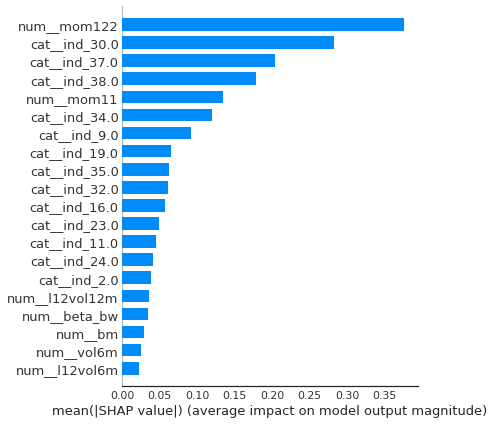

In [81]:
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)

shap.summary_plot(shap_values_XGBoost_test, X_test, 
                  plot_type="bar", plot_size=(6,6), max_display=20)

In [82]:
# Evaluate performance of XGB models:
r2_xgb1 = r2_score(y_test, xgb1.predict(X_test))
r2_xgbgs = r2_score(y_test, xgbgs.predict(X_test))
r2_xgbo = r2_score(y_test, optuna_xgb.predict(X_test))

print('Min_prd: ', min_prd)
print('Constant guess: ', mean_absolute_error(y_test, np.ones(len(y_test))*y_test.mean()), 
      r2_score(y_test, np.ones(len(y_test))*y_test.mean()))
print('XGB test:', mean_absolute_error(y_test, xgb1.predict(X_test)), r2_xgb1)
print('XGB GS test:', mean_absolute_error(y_test, xgbgs.predict(X_test)), r2_xgbgs)
print('Optuna XGB test:', mean_absolute_error(y_test, optuna_xgb.predict(X_test)), r2_xgbo)


Min_prd:  250
Constant guess:  7.924561381034317 0.0
XGB test: 7.84572645024662 0.015254350212336232
XGB GS test: 7.787969462570123 0.02523901836111997
Optuna XGB test: 7.7989497431066175 0.02333983207623147


In [83]:
print('Total time for a script: ', time.time()-time0)

Total time for a script:  95.69957304000854


In [84]:
results.iloc[:,1:].mean()

xgbf_train      0.088074
xgbf_val       -0.012211
xgbf_test       0.015254
xgbgs_train     0.060695
xgbgs_val       0.032498
xgbgs_test      0.025239
xgbo_train      0.057913
xgbo_val        0.027664
xgbo_test       0.023340
nn2_train            NaN
nn2_val              NaN
nn2_test             NaN
nn4_train            NaN
nn4_val              NaN
nn4_test             NaN
nn6_train            NaN
nn6_val              NaN
nn6_test             NaN
nn4opt_train         NaN
nn4opt_val           NaN
nn4opt_test          NaN
dtype: float64

In [85]:
# 3yr window, trials=20, cv_reg=0.03: 0.88%. runs 1 hr.
# 3yr, t=40, cv_reg=0.04: 0.96%.



In [86]:
display(X_train, X_val, X_test)

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
0,-0.574564,-0.711081,0.472308,-0.134353,-1.129718,-0.392313,-0.291318,-0.566625,-0.711182,-0.877729,-0.777803,-0.290435,-0.729070,-0.931525,-1.013542,-1.142541,0.884642,0.282772,-0.127991,-1.106961,-0.536405,1.046549,-0.767426,-0.752765,-0.691502,-1.055559,-0.712044,-0.801846,-0.793977,-0.752765,-0.449638,-0.884437,-0.928455,-0.039010,-1.128689,-1.198377,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.653236,-0.688240,0.472308,-0.134353,-1.129718,-0.392313,-0.256761,-0.281055,-0.725324,-0.863874,-0.841188,-0.390012,-0.914071,-0.929305,-1.037940,-1.204140,0.878183,0.282772,-0.127991,-1.106961,-0.536405,0.976333,-0.720364,-0.738622,-0.729562,-0.627579,-0.666427,-0.880118,-0.766839,-0.738622,-0.432148,-0.441625,-0.316339,0.071654,-1.100925,-1.122707,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.590031,-0.689546,0.472308,-0.134353,-1.129718,-0.392313,-0.247274,-0.277685,-0.762064,-1.125174,-1.126674,-0.400091,-0.890002,-1.089513,-1.077085,-1.203867,0.862794,0.282772,-0.127991,-1.106961,-0.536405,0.958378,-0.734527,-0.921749,-0.788583,-0.745667,-0.697685,-0.599916,-0.750813,-0.921749,-0.711138,-1.087944,-1.068946,0.105760,-1.085436,-1.158464,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.457370,-0.638779,0.472308,-0.134353,-1.129718,-0.392313,0.597571,-0.412356,-0.772104,-0.658278,-0.636945,-0.308280,-0.563560,-0.640612,-1.025729,-1.160449,0.905620,0.282772,-0.127991,-1.106961,-0.536405,0.978536,-0.771321,-0.897924,-0.741403,-0.731403,-0.730937,-1.069933,-0.744892,-0.897924,-0.761080,-0.969431,-0.923707,0.116068,-1.079960,-1.170898,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.604114,-0.623601,0.472308,-0.134353,-1.129718,-0.392313,0.539864,-0.469925,-0.767163,-0.716880,-0.679172,-0.284042,-0.580173,-0.749459,-1.060253,-1.159392,0.945342,0.282772,-0.127991,-1.106961,-0.536405,1.032828,-0.781376,-0.574787,-0.755602,-0.916098,-0.769223,-0.643464,-0.751251,-0.574787,-0.791735,-0.734650,-0.897763,-0.004421,-1.041669,-1.155515,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
36,-0.585324,-0.644216,0.379757,-0.197630,-1.066823,-0.365342,0.388211,-0.899505,-1.038144,-0.560815,-0.445949,-0.416552,-0.303738,-0.659472,-0.982810,-1.166545,1.057885,0.654601,-0.320691,-1.112279,-0.276956,1.216944,-1.089773,-0.902409,-1.187112,-0.977416,-1.333498,-0.924382,-1.189411,-0.902409,0.539004,-0.589160,-0.613450,0.138360,-0.773293,-0.616222,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,-0.726781,-0.772511,0.379757,-0.197630,-1.066823,-0.365342,-0.990431,-0.984266,-0.984656,-0.393243,-0.315458,-0.244301,-0.295420,-0.124462,-0.839646,-1.104340,1.005449,0.654601,-0.320691,-1.112279,-0.276956,1.272056,-1.047810,-0.317597,-1.150335,-0.484600,-1.303997,-0.450954,-1.195741,-0.317597,-0.186181,-0.615879,-0.481990,0.060410,-0.744144,-0.643334,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,-0.719618,-0.431708,0.379757,-0.197630,-1.066823,-0.365342,-0.162117,-1.126915,-0.964176,-0.979260,-0.866734,-0.289412,-0.906472,-0.742458,-0.828203,-1.116244,1.005449,0.654601,-0.320691,-1.112279,-0.276956,1.260143,-0.994242,-0.309362,-1.111737,-0.896592,-1.309644,-1.069933,-1.210686,-0.309362,0.331343,-0.885376,-1.056955,0.024423,-0.842861,-0.659589,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,-0.303435,-1.207074,0.139332,-0.120186,-0.301792,0.217784,0.398875,-1.046352,0.301660,0.074126,0.016825,-0.417008,0.411358,-0.015756,-0.663543,-0.590345,0.318093,-0.045407,0.416153,-0.030640,0.230781,0.503442,0.282370,-0.546595,0.196414,-0.252899,-0.010498,-0.775373,0.086514,-0.546595,-0.519835,0.360269,0.421111,-0.446306,0.136028,-0.091275,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,-0.380104,-1.020176,0.139332,-0.120186,-0.301792,0.217784,0.633951,-0.901490,0.324640,0.380243,0.591793,-0.650563,0.690118,0.252041,-0.472592,-0.656507,0.362862,-0.045407,0.416153,-0.030640,0.230781,0.498180,0.293974,0.390257,0.240561,-0.466554,0.052464,-0.501467,0.075144,0.390257,-1.119754,0.484527,0.439798,-0.325219,0.270547,0.027074,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

,num__mom482,num__mom242,num__bm,num__op,num__gp,num__inv,num__mom11,num__mom122,num__amhd,num__ivol_capm,num__ivol_ff5,num__beta_bw,num__MAX,num__vol1m,num__vol6m,num__vol12m,num__size,num__lbm,num__lop,num__lgp,num__linv,num__llme,num__l1amhd,num__l1MAX,num__l3amhd,num__l3MAX,num__l6amhd,num__l6MAX,num__l12amhd,num__l12MAX,num__l12mom122,num__l12ivol_capm,num__l12ivol_ff5,num__l12beta_bw,num__l12vol6m,num__l12vol12m,num__amhd_miss,cat__ind_1.0,cat__ind_2.0,cat__ind_3.0,cat__ind_4.0,cat__ind_5.0,cat__ind_6.0,cat__ind_7.0,cat__ind_8.0,cat__ind_9.0,cat__ind_10.0,cat__ind_11.0,cat__ind_12.0,cat__ind_13.0,cat__ind_14.0,cat__ind_15.0,cat__ind_16.0,cat__ind_17.0,cat__ind_18.0,cat__ind_19.0,cat__ind_20.0,cat__ind_21.0,cat__ind_22.0,cat__ind_23.0,cat__ind_24.0,cat__ind_25.0,cat__ind_26.0,cat__ind_27.0,cat__ind_28.0,cat__ind_29.0,cat__ind_30.0,cat__ind_31.0,cat__ind_32.0,cat__ind_33.0,cat__ind_34.0,cat__ind_35.0,cat__ind_36.0,cat__ind_37.0,cat__ind_38.0,cat__ind_39.0,cat__ind_40.0,cat__ind_41.0,cat__ind_42.0,cat__ind_43.0,cat__ind_44.0,cat__ind_45.0,cat__ind_47.0,cat__ind_48.0,cat__ind_49.0
39,-0.867368,-0.499066,0.379757,-0.197630,-1.066823,-0.365342,-0.719913,-1.112204,-0.951812,-0.823485,-0.823200,-0.263365,-0.847810,-0.759358,-0.939433,-1.113617,0.960933,0.654601,-0.320691,-1.112279,-0.276956,1.250689,-0.973732,-0.914227,-1.069669,-0.306774,-1.229480,-0.992066,-1.251140,-0.914227,0.966894,-0.782169,-0.887040,-0.205925,-0.916214,-0.819440,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,-0.813073,-0.496274,0.379757,-0.197630,-1.066823,-0.365342,0.469989,-1.102434,-0.895303,-0.483593,-0.413036,-0.226876,-0.565454,-0.561918,-0.899538,-1.067529,0.998287,0.654601,-0.320691,-1.112279,-0.276956,1.214034,-0.961350,-0.856158,-1.015967,-0.298469,-1.192486,-0.500990,-1.317560,-0.856158,1.063903,-0.936993,-0.912128,-0.326780,-0.911090,-0.921379,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,-0.929999,-0.655791,0.379757,-0.197630,-1.066823,-0.365342,-0.795177,-1.090620,-0.873778,-0.981461,-0.907385,-0.229098,-0.911075,-1.073475,-0.913637,-1.073300,0.949190,0.654601,-0.320691,-1.112279,-0.276956,1.241065,-0.904757,-0.576662,-0.995405,-0.908511,-1.153659,-0.911528,-1.374790,-0.576662,0.470431,-1.003227,-1.016788,-0.395446,-1.059311,-0.963268,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,-0.653287,-0.592435,0.139332,-0.120186,-0.301792,0.217784,-0.368547,-0.800143,0.278860,-0.656207,-0.539955,-0.640559,-0.583769,-0.865856,-0.558238,-0.730289,0.327357,-0.045407,0.416153,-0.030640,0.230781,0.499802,0.281703,-0.862803,0.275475,0.407140,0.162234,-0.270107,0.109854,-0.862803,-0.407803,-0.389782,-0.263555,-0.248717,0.162718,0.044085,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,-0.774069,-0.803011,0.139332,-0.120186,-0.301792,0.217784,0.220612,-1.037389,0.297423,-0.625074,-0.481491,-0.609086,-0.852556,-0.668448,-0.591883,-0.773978,0.342443,-0.045407,0.416153,-0.030640,0.230781,0.542960,0.271140,-0.594792,0.298546,0.685439,0.206642,-0.483007,0.032981,-0.594792,0.107700,-0.168599,-0.665567,-0.120194,0.042497,-0.044168,-0.850499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [87]:
neurons_base = 16
dropout_rate = 0.05
# n_b=8 was ok with small overfit.
# n_b=32 starts clearly overfitting. 
# 128 fits clearly slower than 64 and becomes somewhat unstable. regularization could make it work, but i see no reason to go wider.
# 64 seems to have nice balance of flexibility and runtime, but its variance may be too large. dropout makes variance vene worse.
# 6 hidden layers is probably most this architecture can hold

# in this framework the optimal model seems to have width of 16 or 32, somehow regularized. try l1/l2?
# w32 can take at most 0.03 dropout.
# w16 looks good w/o dropout.

# more general point:
# main drawback of dropout is in incresing variance
# for textbook problems with high s/n ratio (e.g., mnist) this may be ok.
# for application like this with very low s/n ratio dropout may be a bad idea.

model_snn = Sequential([
    tf.keras.layers.Dense(units=neurons_base*32, activation="selu", kernel_initializer="lecun_normal", input_shape=X_train.shape[1:]),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*16, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*8, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.AlphaDropout(dropout_rate),
    Dense(1)])

print(model_snn.count_params())

219137


3801
Epoch 1/1000
39/39 - 1s - loss: 172.5755 - mean_squared_error: 134.5504 - val_loss: 154.2018 - val_mean_squared_error: 121.5148
Epoch 2/1000
39/39 - 0s - loss: 161.9323 - mean_squared_error: 133.2315 - val_loss: 146.1073 - val_mean_squared_error: 121.1398
Epoch 3/1000
39/39 - 0s - loss: 154.1943 - mean_squared_error: 131.8636 - val_loss: 140.4110 - val_mean_squared_error: 120.5267
Epoch 4/1000
39/39 - 0s - loss: 148.0542 - mean_squared_error: 129.7760 - val_loss: 136.5850 - val_mean_squared_error: 119.8549
Epoch 5/1000
39/39 - 0s - loss: 143.8352 - mean_squared_error: 128.4040 - val_loss: 134.7204 - val_mean_squared_error: 120.6323
Epoch 6/1000
39/39 - 0s - loss: 140.9676 - mean_squared_error: 127.8915 - val_loss: 132.1978 - val_mean_squared_error: 120.2108
Epoch 7/1000
39/39 - 0s - loss: 139.0842 - mean_squared_error: 127.8966 - val_loss: 129.3222 - val_mean_squared_error: 118.9924
Epoch 8/1000
39/39 - 0s - loss: 137.5868 - mean_squared_error: 127.8361 - val_loss: 128.6589 - val_

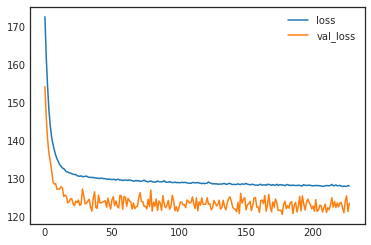

In [88]:
neurons_base = 8
l2_reg_rate = 0.5

model_snn6 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn6.count_params())

# snn: 32-16-8-4 with 30%l2 reg seems to converge to 5.1% test r2.

early_stopping50 = EarlyStopping(patience=50, restore_best_weights=True)
optimizer_adam = tf.keras.optimizers.Adam()

model_snn6.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

time1 = time.time()
history = model_snn6.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn6.predict(X_train)), 
       r2_score(y_val, model_snn6.predict(X_val)),
       r2_score(y_test, model_snn6.predict(X_test))])

results.loc[results.min_prd==min_prd,'nn6_train':'nn6_test'] = \
[r2_score(y_train, model_snn6.predict(X_train)), 
r2_score(y_val, model_snn6.predict(X_val)),
r2_score(y_test, model_snn6.predict(X_test))]

print(time.time()-time1)

3025
Epoch 1/1000
39/39 - 1s - loss: 136.0404 - mean_squared_error: 133.7588 - val_loss: 121.1612 - val_mean_squared_error: 119.5641
Epoch 2/1000
39/39 - 0s - loss: 132.0966 - mean_squared_error: 130.2646 - val_loss: 121.6954 - val_mean_squared_error: 119.5849
Epoch 3/1000
39/39 - 0s - loss: 130.4209 - mean_squared_error: 128.2783 - val_loss: 121.4836 - val_mean_squared_error: 119.4639
Epoch 4/1000
39/39 - 0s - loss: 129.6638 - mean_squared_error: 127.7209 - val_loss: 122.6020 - val_mean_squared_error: 120.7338
Epoch 5/1000
39/39 - 0s - loss: 129.1115 - mean_squared_error: 127.2912 - val_loss: 122.4477 - val_mean_squared_error: 120.7271
Epoch 6/1000
39/39 - 0s - loss: 128.8442 - mean_squared_error: 127.1617 - val_loss: 122.8122 - val_mean_squared_error: 121.1586
Epoch 7/1000
39/39 - 0s - loss: 128.7209 - mean_squared_error: 127.1184 - val_loss: 122.3040 - val_mean_squared_error: 120.7219
Epoch 8/1000
39/39 - 0s - loss: 128.4851 - mean_squared_error: 126.9360 - val_loss: 121.1476 - val_

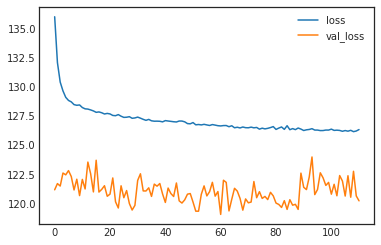

In [89]:
neurons_base = 8
l2_reg_rate = 0.1

model_snn2 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn2.count_params())

model_snn2.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])

time1 = time.time()
history = model_snn2.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn2.predict(X_train)), 
       r2_score(y_val, model_snn2.predict(X_val)),
       r2_score(y_test, model_snn2.predict(X_test))])

results.loc[results.min_prd==min_prd,'nn2_train':'nn2_test'] = \
[r2_score(y_train, model_snn2.predict(X_train)), 
r2_score(y_val, model_snn2.predict(X_val)),
r2_score(y_test, model_snn2.predict(X_test))]

print(time.time()-time1)

3457
Epoch 1/1000
39/39 - 1s - loss: 142.1878 - mean_squared_error: 133.9769 - val_loss: 123.9122 - val_mean_squared_error: 120.6788
Epoch 2/1000
39/39 - 0s - loss: 133.4625 - mean_squared_error: 130.2302 - val_loss: 124.3819 - val_mean_squared_error: 120.9473
Epoch 3/1000
39/39 - 0s - loss: 131.4409 - mean_squared_error: 128.3832 - val_loss: 123.7636 - val_mean_squared_error: 120.8089
Epoch 4/1000
39/39 - 0s - loss: 130.8542 - mean_squared_error: 128.0584 - val_loss: 122.6044 - val_mean_squared_error: 119.8794
Epoch 5/1000
39/39 - 0s - loss: 130.4174 - mean_squared_error: 127.7811 - val_loss: 124.1124 - val_mean_squared_error: 121.4789
Epoch 6/1000
39/39 - 0s - loss: 130.2958 - mean_squared_error: 127.7867 - val_loss: 124.7197 - val_mean_squared_error: 122.2654
Epoch 7/1000
39/39 - 0s - loss: 130.0159 - mean_squared_error: 127.5917 - val_loss: 122.2725 - val_mean_squared_error: 119.8257
Epoch 8/1000
39/39 - 0s - loss: 129.8274 - mean_squared_error: 127.4403 - val_loss: 122.4629 - val_

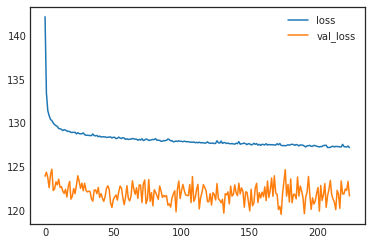

In [90]:
neurons_base = 8
l2_reg_rate = 0.3

model_snn4 = Sequential([
    tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                          kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                         kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
    Dense(1)])

print(model_snn4.count_params())

# snn: 32-16-8-4 with 30%l2 reg seems to converge to 5.1% test r2.

time1 = time.time()
model_snn4.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
history = model_snn4.fit(X_train, y_train, validation_data=(X_val, y_val), 
                         batch_size=2048, epochs=1000, verbose=2, callbacks=[early_stopping50])
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

print([r2_score(y_train, model_snn4.predict(X_train)), 
       r2_score(y_val, model_snn4.predict(X_val)),
       r2_score(y_test, model_snn4.predict(X_test))])
print(time.time()-time1)

results.loc[results.min_prd==min_prd,'nn4_train':'nn4_test'] = \
[r2_score(y_train, model_snn4.predict(X_train)), 
r2_score(y_val, model_snn4.predict(X_val)),
r2_score(y_test, model_snn4.predict(X_test))]

In [91]:
# try optuna, using this kaggle notebook: https://www.kaggle.com/code/mistag/keras-model-tuning-with-optuna

time1 = time.time()

trials = 50

def create_snnn_model_hyperpars(neurons_base=4, l2_reg_rate=0.1):

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

def create_snnn_model(trial):

    # hyperparameter space
    neurons_base = trial.suggest_int("neurons_base", 4, 24, 2)
    l2_reg_rate = trial.suggest_float('l2_regularizer', 0, 0.9)

    model_snn = Sequential([
        tf.keras.layers.Dense(units=neurons_base*4, activation="selu", kernel_initializer="lecun_normal", 
                              kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate), input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(units=neurons_base*2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        tf.keras.layers.Dense(units=neurons_base/2, activation="selu", kernel_initializer="lecun_normal",
                             kernel_regularizer=tf.keras.regularizers.l2(l=l2_reg_rate)),
        Dense(1)])

    optimizer_adam = tf.keras.optimizers.Adam()
    model_snn.compile(loss= "mean_squared_error" , optimizer=optimizer_adam, metrics=["mean_squared_error"])
    
    return model_snn

    
EPOCHS = 10 # number of epocs per trial

def objective(trial):
    
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.
        model = create_snnn_model(trial)

        callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=40),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

        # Fit the model on the training data.
        # The TFKerasPruningCallback checks for pruning condition every epoch.
        
        history = model.fit(X_train, y_train, 
                                validation_data=(X_val, y_val),
                                batch_size=2048, 
                                epochs=500, 
                                verbose=1, 
                                callbacks=callbacks)

        # Evaluate the model accuracy on the validation set.
        score = model.evaluate(X_val, y_val, verbose=0)
        return score[1]
    
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=trials)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
temp = study.best_params
display(study.best_params, time.time()-time1)

[I 2022-09-07 23:07:07,487] A new study created in memory with name: no-name-555c418d-d05b-4cee-98d9-2dee5d1ae29b


Epoch 1/500
39/39 [==============================] - 1s 13ms/step - loss: 158.8216 - mean_squared_error: 135.7080 - val_loss: 141.6604 - val_mean_squared_error: 121.7073
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 151.4613 - mean_squared_error: 133.9155 - val_loss: 136.2607 - val_mean_squared_error: 121.0123
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 146.8669 - mean_squared_error: 133.2771 - val_loss: 132.8095 - val_mean_squared_error: 120.7544
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 143.5581 - mean_squared_error: 132.6139 - val_loss: 130.4428 - val_mean_squared_error: 120.5109
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 141.1838 - mean_squared_error: 131.9647 - val_loss: 128.2241 - val_mean_squared_error: 119.7086
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 139.4149 - mean_squared_error: 131.3515 - val_loss: 127.1029 - val_mean_squared_e

[I 2022-09-07 23:07:37,625] Trial 0 finished with value: 120.9544906616211 and parameters: {'neurons_base': 4, 'l2_regularizer': 0.8325658975522857}. Best is trial 0 with value: 120.9544906616211.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 180.4288 - mean_squared_error: 134.8285 - val_loss: 156.1143 - val_mean_squared_error: 120.4277
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 162.3423 - mean_squared_error: 133.5298 - val_loss: 143.5853 - val_mean_squared_error: 120.9366
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 151.2695 - mean_squared_error: 132.7080 - val_loss: 135.5713 - val_mean_squared_error: 120.6751
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 144.1874 - mean_squared_error: 131.5784 - val_loss: 130.6009 - val_mean_squared_error: 119.9224
Epoch 5/500
39/39 [==============================] - 0s 5ms/step - loss: 139.2289 - mean_squared_error: 129.7267 - val_loss: 128.1122 - val_mean_squared_error: 119.5760
Epoch 6/500
39/39 [==============================] - 0s 7ms/step - loss: 136.0966 - mean_squared_error: 128.3550 - val_loss: 127.0155 - val_mean_squared_er

[I 2022-09-07 23:07:59,117] Trial 1 finished with value: 120.38507843017578 and parameters: {'neurons_base': 16, 'l2_regularizer': 0.4662492437596907}. Best is trial 1 with value: 120.38507843017578.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 160.4699 - mean_squared_error: 134.4401 - val_loss: 143.7713 - val_mean_squared_error: 121.8302
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 151.5065 - mean_squared_error: 132.5400 - val_loss: 137.8357 - val_mean_squared_error: 121.5979
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 145.1861 - mean_squared_error: 130.7675 - val_loss: 133.5177 - val_mean_squared_error: 120.6889
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 140.5609 - mean_squared_error: 128.8109 - val_loss: 130.9458 - val_mean_squared_error: 120.2571


[I 2022-09-07 23:08:00,520] Trial 2 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 143.3312 - mean_squared_error: 136.1524 - val_loss: 124.1511 - val_mean_squared_error: 118.2518
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 140.8163 - mean_squared_error: 135.7628 - val_loss: 122.8388 - val_mean_squared_error: 118.5257
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 139.0306 - mean_squared_error: 135.1628 - val_loss: 122.6048 - val_mean_squared_error: 119.1239
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 137.6716 - mean_squared_error: 134.4220 - val_loss: 122.7336 - val_mean_squared_error: 119.6869
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 136.7164 - mean_squared_error: 133.7856 - val_loss: 122.9236 - val_mean_squared_error: 120.1341
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 135.8803 - mean_squared_error: 133.1409 - val_loss: 122.8714 - val_mean_squared_er

[I 2022-09-07 23:08:03,331] Trial 3 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 171.9720 - mean_squared_error: 134.1813 - val_loss: 152.0456 - val_mean_squared_error: 121.1471
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 158.4686 - mean_squared_error: 132.5014 - val_loss: 142.3904 - val_mean_squared_error: 120.9296
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 149.5468 - mean_squared_error: 131.0805 - val_loss: 134.9372 - val_mean_squared_error: 119.1792
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 143.3293 - mean_squared_error: 129.3574 - val_loss: 131.1338 - val_mean_squared_error: 118.8195
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 139.3187 - mean_squared_error: 128.3019 - val_loss: 129.1176 - val_mean_squared_error: 119.3126
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 136.8610 - mean_squared_error: 127.9799 - val_loss: 128.4452 - val_mean_squared_er

[I 2022-09-07 23:08:30,354] Trial 4 finished with value: 119.56676483154297 and parameters: {'neurons_base': 16, 'l2_regularizer': 0.36203387685375304}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 175.3150 - mean_squared_error: 134.2969 - val_loss: 154.6109 - val_mean_squared_error: 121.5223
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 160.0411 - mean_squared_error: 132.4693 - val_loss: 144.9520 - val_mean_squared_error: 122.3854


[I 2022-09-07 23:08:31,476] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 157.7673 - mean_squared_error: 134.4120 - val_loss: 140.3225 - val_mean_squared_error: 121.3155
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 148.5931 - mean_squared_error: 132.5943 - val_loss: 133.6198 - val_mean_squared_error: 120.2750


[I 2022-09-07 23:08:32,712] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 11ms/step - loss: 178.0993 - mean_squared_error: 133.9240 - val_loss: 156.7405 - val_mean_squared_error: 121.8061
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 160.8155 - mean_squared_error: 132.2103 - val_loss: 143.5234 - val_mean_squared_error: 120.5984


[I 2022-09-07 23:08:34,651] Trial 7 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 162.7351 - mean_squared_error: 136.2270 - val_loss: 145.1173 - val_mean_squared_error: 122.1386
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 154.2953 - mean_squared_error: 134.0403 - val_loss: 139.0801 - val_mean_squared_error: 121.4125


[I 2022-09-07 23:08:35,812] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 165.7169 - mean_squared_error: 134.9836 - val_loss: 147.0124 - val_mean_squared_error: 121.2473
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 154.4290 - mean_squared_error: 132.3157 - val_loss: 139.8450 - val_mean_squared_error: 121.0880


[I 2022-09-07 23:08:37,066] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 159.1601 - mean_squared_error: 136.2250 - val_loss: 137.5511 - val_mean_squared_error: 118.3783
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 151.2697 - mean_squared_error: 134.8375 - val_loss: 133.2859 - val_mean_squared_error: 119.4022
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 146.3678 - mean_squared_error: 134.2866 - val_loss: 130.2637 - val_mean_squared_error: 119.8287
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 143.1481 - mean_squared_error: 133.8841 - val_loss: 128.2441 - val_mean_squared_error: 120.0952
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 140.9375 - mean_squared_error: 133.5698 - val_loss: 126.6419 - val_mean_squared_error: 120.0154
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 139.3929 - mean_squared_error: 133.2724 - val_loss: 125.7135 - val_mean_squared_er

[I 2022-09-07 23:08:51,120] Trial 10 pruned. Trial was pruned at epoch 81.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 171.5309 - mean_squared_error: 134.5685 - val_loss: 151.7913 - val_mean_squared_error: 120.8701
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 159.8602 - mean_squared_error: 133.4096 - val_loss: 143.3317 - val_mean_squared_error: 121.0616
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 152.1747 - mean_squared_error: 132.9024 - val_loss: 137.5050 - val_mean_squared_error: 121.0308
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 146.9234 - mean_squared_error: 132.4479 - val_loss: 133.4801 - val_mean_squared_error: 120.8379
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 143.2933 - mean_squared_error: 131.9640 - val_loss: 130.4871 - val_mean_squared_error: 120.3727
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 140.6935 - mean_squared_error: 131.3814 - val_loss: 128.4869 - val_mean_squared_er

[I 2022-09-07 23:09:33,054] Trial 11 finished with value: 122.04044342041016 and parameters: {'neurons_base': 6, 'l2_regularizer': 0.8888698622268734}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 144.5840 - mean_squared_error: 134.7993 - val_loss: 130.8458 - val_mean_squared_error: 122.0749
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 140.6954 - mean_squared_error: 132.6875 - val_loss: 128.2903 - val_mean_squared_error: 120.9761
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 138.0022 - mean_squared_error: 131.1340 - val_loss: 127.2409 - val_mean_squared_error: 120.7659
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.5904 - mean_squared_error: 129.3510 - val_loss: 126.6821 - val_mean_squared_error: 120.6532
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 133.9886 - mean_squared_error: 128.1500 - val_loss: 127.5256 - val_mean_squared_error: 121.8975
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 133.0692 - mean_squared_error: 127.6657 - val_loss: 125.2928 - val_mean_squared_e

[I 2022-09-07 23:09:38,101] Trial 12 pruned. Trial was pruned at epoch 27.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 158.4692 - mean_squared_error: 133.7806 - val_loss: 142.5218 - val_mean_squared_error: 121.6873
Epoch 2/500
39/39 [==============================] - 0s 7ms/step - loss: 149.5205 - mean_squared_error: 131.3382 - val_loss: 135.5741 - val_mean_squared_error: 119.7792
Epoch 3/500
39/39 [==============================] - 0s 5ms/step - loss: 143.1740 - mean_squared_error: 128.9347 - val_loss: 132.7138 - val_mean_squared_error: 119.9326
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 139.4586 - mean_squared_error: 127.8184 - val_loss: 130.0191 - val_mean_squared_error: 119.5291


[I 2022-09-07 23:09:40,428] Trial 13 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 152.6791 - mean_squared_error: 133.3671 - val_loss: 138.6034 - val_mean_squared_error: 121.8796
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 145.6472 - mean_squared_error: 130.7016 - val_loss: 135.4443 - val_mean_squared_error: 122.0669
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 140.6705 - mean_squared_error: 128.3453 - val_loss: 132.8368 - val_mean_squared_error: 121.5337
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 137.8001 - mean_squared_error: 127.3577 - val_loss: 130.4070 - val_mean_squared_error: 120.7917


[I 2022-09-07 23:09:42,179] Trial 14 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 141.2016 - mean_squared_error: 134.4787 - val_loss: 128.2028 - val_mean_squared_error: 122.1079
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 138.1610 - mean_squared_error: 132.5113 - val_loss: 126.9448 - val_mean_squared_error: 121.6884
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 135.8788 - mean_squared_error: 130.8412 - val_loss: 126.4880 - val_mean_squared_error: 121.6278
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 133.5579 - mean_squared_error: 128.7925 - val_loss: 126.2328 - val_mean_squared_error: 121.5685


[I 2022-09-07 23:09:44,008] Trial 15 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 12ms/step - loss: 194.4318 - mean_squared_error: 134.3671 - val_loss: 166.7951 - val_mean_squared_error: 120.0688
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 171.0723 - mean_squared_error: 133.4381 - val_loss: 149.8118 - val_mean_squared_error: 120.3769
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 156.8889 - mean_squared_error: 132.9136 - val_loss: 139.8135 - val_mean_squared_error: 120.7078
Epoch 4/500
39/39 [==============================] - 0s 6ms/step - loss: 148.1282 - mean_squared_error: 132.2270 - val_loss: 133.4041 - val_mean_squared_error: 120.3160


[I 2022-09-07 23:09:45,824] Trial 16 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 143.6933 - mean_squared_error: 135.4449 - val_loss: 127.1022 - val_mean_squared_error: 120.0387
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 140.1425 - mean_squared_error: 133.9382 - val_loss: 126.2375 - val_mean_squared_error: 120.8208
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 137.7509 - mean_squared_error: 132.8335 - val_loss: 125.1961 - val_mean_squared_error: 120.7152
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.4967 - mean_squared_error: 131.2386 - val_loss: 123.0549 - val_mean_squared_error: 118.9248
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 133.3951 - mean_squared_error: 129.3248 - val_loss: 123.1047 - val_mean_squared_error: 119.1307
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 132.2435 - mean_squared_error: 128.4476 - val_loss: 123.9927 - val_mean_squared_er

[I 2022-09-07 23:10:01,624] Trial 17 finished with value: 121.72562408447266 and parameters: {'neurons_base': 8, 'l2_regularizer': 0.15865264047678732}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 174.7755 - mean_squared_error: 135.3618 - val_loss: 152.3773 - val_mean_squared_error: 120.5811
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 160.2800 - mean_squared_error: 133.8451 - val_loss: 142.4491 - val_mean_squared_error: 120.9083


[I 2022-09-07 23:10:02,968] Trial 18 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 150.1689 - mean_squared_error: 134.7399 - val_loss: 134.5594 - val_mean_squared_error: 121.1089
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 145.0747 - mean_squared_error: 133.1824 - val_loss: 131.0913 - val_mean_squared_error: 120.6653
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 142.0065 - mean_squared_error: 132.6311 - val_loss: 128.4783 - val_mean_squared_error: 120.0652
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 139.7479 - mean_squared_error: 131.9851 - val_loss: 126.4688 - val_mean_squared_error: 119.3153


[I 2022-09-07 23:10:04,419] Trial 19 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 170.8882 - mean_squared_error: 135.2367 - val_loss: 150.2880 - val_mean_squared_error: 121.1648
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 158.1536 - mean_squared_error: 133.7812 - val_loss: 141.2117 - val_mean_squared_error: 121.2548


[I 2022-09-07 23:10:05,998] Trial 20 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 198.0923 - mean_squared_error: 135.0351 - val_loss: 171.4710 - val_mean_squared_error: 121.1385
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 174.4271 - mean_squared_error: 133.2268 - val_loss: 153.4874 - val_mean_squared_error: 120.6753
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 159.5780 - mean_squared_error: 132.4290 - val_loss: 142.6229 - val_mean_squared_error: 120.6265
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 149.9382 - mean_squared_error: 131.3334 - val_loss: 136.4733 - val_mean_squared_error: 120.8978
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 143.6220 - mean_squared_error: 129.9425 - val_loss: 132.4974 - val_mean_squared_error: 120.5763
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 139.3570 - mean_squared_error: 128.6894 - val_loss: 128.5087 - val_mean_squared_er

[I 2022-09-07 23:10:26,889] Trial 21 finished with value: 120.26500701904297 and parameters: {'neurons_base': 16, 'l2_regularizer': 0.6431399403082437}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 134.3611 - mean_squared_error: 134.2707 - val_loss: 121.4389 - val_mean_squared_error: 121.3474
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 132.1369 - mean_squared_error: 132.0431 - val_loss: 120.4345 - val_mean_squared_error: 120.3377
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 129.6598 - mean_squared_error: 129.5591 - val_loss: 121.2760 - val_mean_squared_error: 121.1710
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 127.9208 - mean_squared_error: 127.8130 - val_loss: 121.2996 - val_mean_squared_error: 121.1895
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 127.3432 - mean_squared_error: 127.2317 - val_loss: 121.0357 - val_mean_squared_error: 120.9231
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 127.0696 - mean_squared_error: 126.9561 - val_loss: 120.9672 - val_mean_squared_er

[I 2022-09-07 23:10:48,742] Trial 22 finished with value: 122.07939910888672 and parameters: {'neurons_base': 8, 'l2_regularizer': 0.0015496077771672502}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 161.7256 - mean_squared_error: 136.0455 - val_loss: 139.4950 - val_mean_squared_error: 119.0746
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 152.1488 - mean_squared_error: 135.2778 - val_loss: 132.8439 - val_mean_squared_error: 119.1800
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 146.3447 - mean_squared_error: 134.8303 - val_loss: 129.0380 - val_mean_squared_error: 119.4606
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 142.7472 - mean_squared_error: 134.4433 - val_loss: 126.6834 - val_mean_squared_error: 119.6080


[I 2022-09-07 23:10:50,840] Trial 23 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 224.6944 - mean_squared_error: 134.4217 - val_loss: 190.5427 - val_mean_squared_error: 121.0937
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 188.2303 - mean_squared_error: 132.9818 - val_loss: 164.2986 - val_mean_squared_error: 121.7391


[I 2022-09-07 23:10:52,003] Trial 24 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 134.8417 - mean_squared_error: 134.4573 - val_loss: 121.8578 - val_mean_squared_error: 121.4744
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 132.6707 - mean_squared_error: 132.2832 - val_loss: 121.4508 - val_mean_squared_error: 121.0554
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 130.2176 - mean_squared_error: 129.8094 - val_loss: 120.3938 - val_mean_squared_error: 119.9701
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 128.3999 - mean_squared_error: 127.9638 - val_loss: 120.7561 - val_mean_squared_error: 120.3112
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 127.9195 - mean_squared_error: 127.4702 - val_loss: 120.9092 - val_mean_squared_error: 120.4569
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 127.5604 - mean_squared_error: 127.1063 - val_loss: 122.0444 - val_mean_squared_er

[I 2022-09-07 23:11:05,853] Trial 25 pruned. Trial was pruned at epoch 81.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 133.5525 - mean_squared_error: 133.0821 - val_loss: 120.6537 - val_mean_squared_error: 120.1824
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 130.1492 - mean_squared_error: 129.6725 - val_loss: 119.4482 - val_mean_squared_error: 118.9643
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 127.9694 - mean_squared_error: 127.4798 - val_loss: 120.4697 - val_mean_squared_error: 119.9757
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 127.3503 - mean_squared_error: 126.8545 - val_loss: 119.1292 - val_mean_squared_error: 118.6322
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 127.0227 - mean_squared_error: 126.5237 - val_loss: 120.5929 - val_mean_squared_error: 120.0927
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 126.7583 - mean_squared_error: 126.2574 - val_loss: 118.6377 - val_mean_squared_er

[I 2022-09-07 23:11:17,104] Trial 26 finished with value: 122.58324432373047 and parameters: {'neurons_base': 18, 'l2_regularizer': 0.0034466991487585807}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 169.5437 - mean_squared_error: 134.5443 - val_loss: 149.3357 - val_mean_squared_error: 121.1455
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 156.5735 - mean_squared_error: 133.2167 - val_loss: 140.0498 - val_mean_squared_error: 121.1015


[I 2022-09-07 23:11:18,237] Trial 27 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 10ms/step - loss: 134.7666 - mean_squared_error: 134.4223 - val_loss: 122.4452 - val_mean_squared_error: 122.1010
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 132.4155 - mean_squared_error: 132.0685 - val_loss: 121.5259 - val_mean_squared_error: 121.1741
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 130.1639 - mean_squared_error: 129.8041 - val_loss: 120.5662 - val_mean_squared_error: 120.1964
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 128.2436 - mean_squared_error: 127.8655 - val_loss: 121.7785 - val_mean_squared_error: 121.3929
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 127.5350 - mean_squared_error: 127.1457 - val_loss: 122.2894 - val_mean_squared_error: 121.8963
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 127.2819 - mean_squared_error: 126.8863 - val_loss: 119.5487 - val_mean_squared_e

[I 2022-09-07 23:11:30,376] Trial 28 finished with value: 121.54133605957031 and parameters: {'neurons_base': 8, 'l2_regularizer': 0.005795130935725642}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 217.9604 - mean_squared_error: 134.0876 - val_loss: 184.4899 - val_mean_squared_error: 121.2127
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 182.8409 - mean_squared_error: 133.1267 - val_loss: 160.1017 - val_mean_squared_error: 122.4333
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 162.3477 - mean_squared_error: 132.4600 - val_loss: 143.3802 - val_mean_squared_error: 120.3504
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 150.3229 - mean_squared_error: 131.5539 - val_loss: 134.0677 - val_mean_squared_error: 119.0913
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 142.9216 - mean_squared_error: 130.1400 - val_loss: 131.8833 - val_mean_squared_error: 121.0376
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 138.3912 - mean_squared_error: 128.8368 - val_loss: 129.0760 - val_mean_squared_er

[I 2022-09-07 23:11:32,675] Trial 29 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 163.9967 - mean_squared_error: 133.8743 - val_loss: 145.8294 - val_mean_squared_error: 120.6896
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 153.4237 - mean_squared_error: 131.8287 - val_loss: 139.0218 - val_mean_squared_error: 120.6983
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 146.0263 - mean_squared_error: 129.8573 - val_loss: 134.5404 - val_mean_squared_error: 120.3232
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 141.1648 - mean_squared_error: 128.3529 - val_loss: 131.5216 - val_mean_squared_error: 120.0676
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 138.2499 - mean_squared_error: 127.8786 - val_loss: 131.4790 - val_mean_squared_error: 122.0951
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 136.2984 - mean_squared_error: 127.6852 - val_loss: 128.3204 - val_mean_squared_er

[I 2022-09-07 23:11:46,833] Trial 30 pruned. Trial was pruned at epoch 81.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 134.8988 - mean_squared_error: 134.0450 - val_loss: 122.2613 - val_mean_squared_error: 121.4197
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 131.9345 - mean_squared_error: 131.0913 - val_loss: 122.2597 - val_mean_squared_error: 121.4060
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 128.8833 - mean_squared_error: 128.0157 - val_loss: 122.1582 - val_mean_squared_error: 121.2808
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 127.9154 - mean_squared_error: 127.0370 - val_loss: 121.0976 - val_mean_squared_error: 120.2183
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 127.4628 - mean_squared_error: 126.5849 - val_loss: 122.0234 - val_mean_squared_error: 121.1478
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 127.3159 - mean_squared_error: 126.4415 - val_loss: 121.1111 - val_mean_squared_er

[I 2022-09-07 23:11:49,193] Trial 31 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 189.5331 - mean_squared_error: 135.9424 - val_loss: 161.4807 - val_mean_squared_error: 119.5385
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 168.6762 - mean_squared_error: 134.7286 - val_loss: 146.6788 - val_mean_squared_error: 119.9164


[I 2022-09-07 23:11:51,556] Trial 32 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 194.6234 - mean_squared_error: 133.9157 - val_loss: 169.8566 - val_mean_squared_error: 121.6130
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 171.7299 - mean_squared_error: 132.2874 - val_loss: 151.9718 - val_mean_squared_error: 120.5609


[I 2022-09-07 23:11:52,982] Trial 33 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 147.6866 - mean_squared_error: 134.5793 - val_loss: 132.6013 - val_mean_squared_error: 121.1055
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 143.2415 - mean_squared_error: 132.9166 - val_loss: 130.6290 - val_mean_squared_error: 121.3891
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 140.4871 - mean_squared_error: 131.9969 - val_loss: 128.7350 - val_mean_squared_error: 120.9410
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 138.3927 - mean_squared_error: 131.0268 - val_loss: 126.8890 - val_mean_squared_error: 119.9301


[I 2022-09-07 23:11:54,573] Trial 34 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 179.9806 - mean_squared_error: 135.5375 - val_loss: 156.3422 - val_mean_squared_error: 120.6008
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 163.8688 - mean_squared_error: 134.2641 - val_loss: 144.6819 - val_mean_squared_error: 120.6792
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 153.8213 - mean_squared_error: 133.6472 - val_loss: 137.5443 - val_mean_squared_error: 120.8931
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 147.3753 - mean_squared_error: 133.1045 - val_loss: 132.4955 - val_mean_squared_error: 120.4212


[I 2022-09-07 23:11:56,424] Trial 35 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 145.1437 - mean_squared_error: 134.7928 - val_loss: 130.4972 - val_mean_squared_error: 121.2986
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 141.2828 - mean_squared_error: 132.9464 - val_loss: 127.8111 - val_mean_squared_error: 120.2530
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 138.2370 - mean_squared_error: 131.1680 - val_loss: 126.2654 - val_mean_squared_error: 119.6160
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 135.7493 - mean_squared_error: 129.3614 - val_loss: 126.0303 - val_mean_squared_error: 119.8950


[I 2022-09-07 23:11:57,880] Trial 36 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 213.7333 - mean_squared_error: 134.1544 - val_loss: 183.7004 - val_mean_squared_error: 121.7621
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 182.6342 - mean_squared_error: 132.7331 - val_loss: 160.3646 - val_mean_squared_error: 121.2834
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 163.3681 - mean_squared_error: 131.3853 - val_loss: 147.0961 - val_mean_squared_error: 121.3988
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 151.2822 - mean_squared_error: 129.6727 - val_loss: 138.2326 - val_mean_squared_error: 120.2515
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 144.1281 - mean_squared_error: 128.6769 - val_loss: 132.6820 - val_mean_squared_error: 119.6754
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 139.5554 - mean_squared_error: 128.1770 - val_loss: 130.5865 - val_mean_squared_er

[I 2022-09-07 23:12:17,970] Trial 37 finished with value: 120.07179260253906 and parameters: {'neurons_base': 20, 'l2_regularizer': 0.634520564257985}. Best is trial 4 with value: 119.56676483154297.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 137.6572 - mean_squared_error: 134.4008 - val_loss: 125.2453 - val_mean_squared_error: 122.1273
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 134.7558 - mean_squared_error: 131.7339 - val_loss: 124.0307 - val_mean_squared_error: 121.0905
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 132.4576 - mean_squared_error: 129.5510 - val_loss: 123.2894 - val_mean_squared_error: 120.4060
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 130.8555 - mean_squared_error: 128.0030 - val_loss: 123.3294 - val_mean_squared_error: 120.5139
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 130.1184 - mean_squared_error: 127.3530 - val_loss: 122.9215 - val_mean_squared_error: 120.2117
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 129.7156 - mean_squared_error: 127.0523 - val_loss: 122.8578 - val_mean_squared_er

[I 2022-09-07 23:12:20,245] Trial 38 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 2s 30ms/step - loss: 193.5221 - mean_squared_error: 134.5045 - val_loss: 166.8891 - val_mean_squared_error: 120.4258
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 170.9866 - mean_squared_error: 133.2252 - val_loss: 150.4084 - val_mean_squared_error: 120.5747
Epoch 3/500
39/39 [==============================] - 0s 5ms/step - loss: 157.0527 - mean_squared_error: 132.4377 - val_loss: 139.7118 - val_mean_squared_error: 119.8373
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 148.2163 - mean_squared_error: 131.3554 - val_loss: 134.5292 - val_mean_squared_error: 120.3602
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 142.1515 - mean_squared_error: 129.6212 - val_loss: 132.3705 - val_mean_squared_error: 121.3254
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 138.5168 - mean_squared_error: 128.6039 - val_loss: 128.7104 - val_mean_squared_e

[I 2022-09-07 23:12:23,549] Trial 39 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 151.7632 - mean_squared_error: 134.7634 - val_loss: 135.3666 - val_mean_squared_error: 120.9886
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 145.8700 - mean_squared_error: 133.3954 - val_loss: 131.8777 - val_mean_squared_error: 121.1532
Epoch 3/500
39/39 [==============================] - 0s 7ms/step - loss: 142.0718 - mean_squared_error: 132.5382 - val_loss: 129.1475 - val_mean_squared_error: 120.7008
Epoch 4/500
39/39 [==============================] - 0s 5ms/step - loss: 139.2576 - mean_squared_error: 131.4867 - val_loss: 127.8299 - val_mean_squared_error: 120.6481
Epoch 5/500
39/39 [==============================] - 0s 5ms/step - loss: 136.9567 - mean_squared_error: 130.0925 - val_loss: 127.2686 - val_mean_squared_error: 120.6992
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 135.1628 - mean_squared_error: 128.7914 - val_loss: 127.4334 - val_mean_squared_er

[I 2022-09-07 23:12:37,161] Trial 40 pruned. Trial was pruned at epoch 81.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 134.9468 - mean_squared_error: 133.9322 - val_loss: 123.5075 - val_mean_squared_error: 122.5091
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 132.8579 - mean_squared_error: 131.8640 - val_loss: 121.4451 - val_mean_squared_error: 120.4471
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 130.5393 - mean_squared_error: 129.5224 - val_loss: 121.0007 - val_mean_squared_error: 119.9635
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 128.8398 - mean_squared_error: 127.7868 - val_loss: 122.2818 - val_mean_squared_error: 121.2190


[I 2022-09-07 23:12:46,192] Trial 41 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 12ms/step - loss: 138.4617 - mean_squared_error: 135.4381 - val_loss: 123.1979 - val_mean_squared_error: 120.3287
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 135.6036 - mean_squared_error: 132.8461 - val_loss: 122.8021 - val_mean_squared_error: 120.1399
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 133.6815 - mean_squared_error: 131.0596 - val_loss: 121.6883 - val_mean_squared_error: 119.0894
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 131.7462 - mean_squared_error: 129.1427 - val_loss: 121.6923 - val_mean_squared_error: 119.0876
Epoch 5/500
39/39 [==============================] - 0s 4ms/step - loss: 130.6732 - mean_squared_error: 128.0813 - val_loss: 121.5474 - val_mean_squared_error: 118.9836
Epoch 6/500
39/39 [==============================] - 0s 4ms/step - loss: 130.0950 - mean_squared_error: 127.5696 - val_loss: 123.3231 - val_mean_squared_e

[I 2022-09-07 23:12:48,853] Trial 42 pruned. Trial was pruned at epoch 9.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 141.4511 - mean_squared_error: 135.0282 - val_loss: 127.5829 - val_mean_squared_error: 121.8117
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 138.0789 - mean_squared_error: 132.7490 - val_loss: 126.6093 - val_mean_squared_error: 121.6637
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 135.1774 - mean_squared_error: 130.4175 - val_loss: 124.4585 - val_mean_squared_error: 119.8323
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 132.6220 - mean_squared_error: 128.0857 - val_loss: 124.7919 - val_mean_squared_error: 120.3766


[I 2022-09-07 23:12:50,314] Trial 43 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 174.7829 - mean_squared_error: 134.6919 - val_loss: 152.8950 - val_mean_squared_error: 120.4986
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 160.0214 - mean_squared_error: 133.0916 - val_loss: 143.0852 - val_mean_squared_error: 121.1204


[I 2022-09-07 23:12:51,890] Trial 44 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 13ms/step - loss: 141.4175 - mean_squared_error: 134.4053 - val_loss: 127.0898 - val_mean_squared_error: 120.7654
Epoch 2/500
39/39 [==============================] - 0s 6ms/step - loss: 138.6586 - mean_squared_error: 132.8194 - val_loss: 126.1664 - val_mean_squared_error: 120.7693
Epoch 3/500
39/39 [==============================] - 0s 6ms/step - loss: 136.6615 - mean_squared_error: 131.5285 - val_loss: 124.5491 - val_mean_squared_error: 119.6425
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 134.6620 - mean_squared_error: 129.8542 - val_loss: 125.8658 - val_mean_squared_error: 121.1274


[I 2022-09-07 23:12:53,942] Trial 45 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 160.2793 - mean_squared_error: 133.8727 - val_loss: 143.9365 - val_mean_squared_error: 121.6840
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 150.8137 - mean_squared_error: 131.5477 - val_loss: 136.6181 - val_mean_squared_error: 120.0575
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 143.9594 - mean_squared_error: 129.1383 - val_loss: 133.2299 - val_mean_squared_error: 120.0439
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 139.8090 - mean_squared_error: 127.8709 - val_loss: 132.4214 - val_mean_squared_error: 121.7501


[I 2022-09-07 23:12:55,490] Trial 46 pruned. Trial was pruned at epoch 3.


Epoch 1/500
39/39 [==============================] - 1s 9ms/step - loss: 176.8209 - mean_squared_error: 134.4437 - val_loss: 155.4894 - val_mean_squared_error: 121.2209
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 160.9574 - mean_squared_error: 132.4764 - val_loss: 143.9357 - val_mean_squared_error: 120.7385


[I 2022-09-07 23:12:57,101] Trial 47 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 13ms/step - loss: 149.0082 - mean_squared_error: 135.4633 - val_loss: 131.3031 - val_mean_squared_error: 119.9964
Epoch 2/500
39/39 [==============================] - 0s 5ms/step - loss: 143.5344 - mean_squared_error: 133.8233 - val_loss: 129.5538 - val_mean_squared_error: 121.2851


[I 2022-09-07 23:12:58,529] Trial 48 pruned. Trial was pruned at epoch 1.


Epoch 1/500
39/39 [==============================] - 1s 8ms/step - loss: 171.9758 - mean_squared_error: 134.3115 - val_loss: 151.4964 - val_mean_squared_error: 121.0827
Epoch 2/500
39/39 [==============================] - 0s 4ms/step - loss: 158.4224 - mean_squared_error: 133.1082 - val_loss: 142.0135 - val_mean_squared_error: 121.3302
Epoch 3/500
39/39 [==============================] - 0s 4ms/step - loss: 149.7678 - mean_squared_error: 132.1916 - val_loss: 134.9511 - val_mean_squared_error: 120.2025
Epoch 4/500
39/39 [==============================] - 0s 4ms/step - loss: 143.6862 - mean_squared_error: 130.7143 - val_loss: 131.5473 - val_mean_squared_error: 120.1188


[I 2022-09-07 23:13:00,030] Trial 49 pruned. Trial was pruned at epoch 3.


{'neurons_base': 16, 'l2_regularizer': 0.36203387685375304}

352.54783368110657

In [92]:
optimal_hyperpars = list(temp.values())
optimal_hyperpars

[16, 0.36203387685375304]

In [93]:
optuna_nn = create_snnn_model_hyperpars(neurons_base=optimal_hyperpars[0], l2_reg_rate=optimal_hyperpars[1])
history = optuna_nn.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        batch_size=2048, 
                        epochs=1000,
                        verbose=1, 
                        callbacks=[early_stopping50])

[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]

results.loc[results.min_prd==min_prd,'nn4opt_train':'nn4opt_test'] = \
[r2_score(y_train, optuna_nn.predict(X_train)), 
r2_score(y_val, optuna_nn.predict(X_val)),
r2_score(y_test, optuna_nn.predict(X_test))]

Epoch 1/1000
39/39 [==============================] - 1s 9ms/step - loss: 172.4088 - mean_squared_error: 134.1057 - val_loss: 153.4448 - val_mean_squared_error: 121.2577
Epoch 2/1000
39/39 [==============================] - 0s 4ms/step - loss: 159.7578 - mean_squared_error: 132.0792 - val_loss: 145.1432 - val_mean_squared_error: 121.6494
Epoch 3/1000
39/39 [==============================] - 0s 4ms/step - loss: 150.9238 - mean_squared_error: 130.3237 - val_loss: 137.6552 - val_mean_squared_error: 119.6816
Epoch 4/1000
39/39 [==============================] - 0s 4ms/step - loss: 144.7142 - mean_squared_error: 128.5732 - val_loss: 137.5326 - val_mean_squared_error: 123.1649
Epoch 5/1000
39/39 [==============================] - 0s 4ms/step - loss: 140.7738 - mean_squared_error: 127.7518 - val_loss: 130.6389 - val_mean_squared_error: 118.9477
Epoch 6/1000
39/39 [==============================] - 0s 4ms/step - loss: 138.2844 - mean_squared_error: 127.5598 - val_loss: 131.0979 - val_mean_squa

In [94]:
display(time.time()-time0, results)

600.503023147583

,min_prd,xgbf_train,xgbf_val,xgbf_test,xgbgs_train,xgbgs_val,xgbgs_test,xgbo_train,xgbo_val,xgbo_test,nn2_train,nn2_val,nn2_test,nn4_train,nn4_val,nn4_test,nn6_train,nn6_val,nn6_test,nn4opt_train,nn4opt_val,nn4opt_test
0,250,0.088074,-0.012211,0.015254,0.060695,0.032498,0.025239,0.057913,0.027664,0.02334,0.077422,-0.001397,0.003514,0.076126,-0.002248,0.013601,0.0774,-0.002073,0.010903,0.076956,0.001191,0.016839


In [20]:
# try optuna for NN:

def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 3)
    model = tf.keras.Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    display(model.summary())
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)


[I 2022-09-07 22:03:28,634] A new study created in memory with name: no-name-eabf0cfc-87b5-4e10-9916-a287739dba76
[W 2022-09-07 22:03:28,642] Trial 0 failed because of the following error: ValueError('This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_17/3767762731.py", line 11, in objective
    display(model.summary())
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 2521, in summary
    raise ValueError('This model has not yet been built. '
ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for 

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [ ]:
model_snn.summary()

In [ ]:
# on nns:
# - try classic regularizers (l1, l2 etc)
# - try different architecture (not snnn)
# classic architecture:
# He initialization, elu activation, batch norm, l2 reg, adam.

# - try exotic architecture, e.g., wide'n'deep
# 


In [ ]:
# usually self-norm seems better: it overfits less and runs faster

